How many of the checkins have descriptions for the beer?

In [3]:
import numpy as np
import pandas as pd


In [4]:
descrips = pd.read_csv('descriptions.csv', nrows=1)
descrips

,beer_id,beer_description
0,2095023,To create a recipe so tropical and fruity with...


In [5]:
descrips = pd.read_csv('descriptions.csv')
print(len(descrips), descrips.beer_id.nunique())

114347 114347


And how many of all the checkins have descriptions?

In [6]:
checkins = pd.read_csv('comboframe.csv', usecols=['beer_id'])

In [7]:
len(pd.merge(checkins, descrips, how='inner'))

1531277

In [8]:
checkins = pd.read_csv('comboframe.csv', usecols=['checkin_id','beer_id', 'rating_user',
                                                  'rating_global', 'user_id',
                                                  'abv', 'brewery_name',
                                                  'beer_style', 'beer_name'])

In [9]:
checkins.shape

(2061965, 9)

In [10]:
checkins.drop_duplicates(subset=['beer_id', 'user_id'], inplace=True)

checkins.shape

(1894852, 9)

In [11]:
checkins = checkins.merge(descrips, how='inner')
checkins.shape

(1394388, 10)

In [13]:
checkins.head(2)

,checkin_id,beer_id,user_id,rating_user,brewery_name,beer_name,beer_style,rating_global,abv,beer_description
0,821797539,2095023,3340203,3.75,Stone Brewing,Stone Scorpion Bowl IPA,IPA - American,3.73789,7.5,To create a recipe so tropical and fruity with...
1,793777280,2095023,2166716,3.50,Stone Brewing,Stone Scorpion Bowl IPA,IPA - American,3.73789,7.5,To create a recipe so tropical and fruity with...


In [14]:
checkins.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1394388 entries, 0 to 1394387
Data columns (total 10 columns):
checkin_id          1394388 non-null int64
beer_id             1394388 non-null int64
user_id             1394388 non-null int64
rating_user         1394388 non-null float64
brewery_name        1394388 non-null object
beer_name           1394388 non-null object
beer_style          1394388 non-null object
rating_global       1369092 non-null float64
abv                 1394388 non-null float64
beer_description    1394388 non-null object
dtypes: float64(3), int64(3), object(4)
memory usage: 117.0+ MB


In [15]:
# cut the non-globally rated, which are only 2% of the data
checkins.dropna(subset=['rating_global'], axis=0, inplace=True)

In [16]:
checkins.shape

(1369092, 10)

In [17]:
sum(checkins.rating_global == 0)

2488

In [18]:
# get rid of those, too
checkins = checkins[checkins.rating_global > 0]
checkins.shape

(1366604, 10)

### Let's try to find which particular words tend to align with each rater's tastes

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [17]:
# lower the max_df to 0.17 to keep 'hop' and 'dry' but not 'brewed' and 'ale'.
cv = CountVectorizer(stop_words='english', min_df=10, max_df=0.17, binary=True)
vecs = cv.fit_transform(descrips.beer_description)
vecs.shape

(114347, 11857)

In [420]:
#cv = CountVectorizer(stop_words='english', min_df=20, max_df=0.57, binary=True)

Had slightly better results with a wider min-max_df spread:

In [17]:
#cv = CountVectorizer(stop_words='english', min_df=10, max_df=0.71, binary=True)

First, without regards to specific users, how well do the words predict the global rating?

In [20]:
by_beer = checkins.groupby('beer_id')

descrips['abv'] = descrips.beer_id.map(dict(by_beer['abv'].mean()))
descrips['rating_global'] = descrips.beer_id.map(dict(by_beer['rating_global'].mean()))

In [21]:
droppers = descrips.rating_global.isna()
sum(droppers)

1377

In [22]:
descrips = descrips[~droppers]
descrips.shape

(112970, 4)

In [102]:
#checkins.set_index('beer_id', inplace=True)

In [21]:
#checkins.head()

In [23]:
descrips.head(1)

,beer_id,beer_description,abv,rating_global
0,2095023,To create a recipe so tropical and fruity with...,7.5,3.73789


In [24]:
descrips['brewery_name'] = descrips.beer_id.map(dict(by_beer['brewery_name'].max(key=len)))
descrips['beer_name'] = descrips.beer_id.map(dict(by_beer['beer_name'].max(key=len)))
descrips['beer_style'] = descrips.beer_id.map(dict(by_beer['beer_style'].max(key=len)))

In [25]:
descrips['beer_description'] = descrips.brewery_name + ' ' + descrips.beer_name + ' ' + descrips.beer_description

In [26]:
descrips.head(1)

,beer_id,beer_description,abv,rating_global,brewery_name,beer_name,beer_style
0,2095023,Stone Brewing Stone Scorpion Bowl IPA To creat...,7.5,3.73789,Stone Brewing,Stone Scorpion Bowl IPA,IPA - American


In [27]:
vecs = cv.fit_transform(descrips.beer_description)
vecs.shape

(112970, 14937)

In [30]:
from scipy.sparse import csr_matrix, hstack
vecs = hstack([vecs, descrips.abv.values[:, np.newaxis] / 5.0])

one-hot the beer style and hstack to vecs

In [31]:
ohe = OneHotEncoder(sparse=True)

styles = ohe.fit_transform([descrips['beer_style']])

vecs = hstack([vecs, styles.transpose()])

vecs = csr_matrix(vecs)

Add global rating to vecs

In [32]:
vecs = hstack([vecs, descrips.rating_global.values[:, np.newaxis]])
vecs = csr_matrix(vecs)

Checking the vecs:

In [33]:
row1 = vecs.toarray()[0, :]

In [34]:
row1[-3:]   # abv/5.0, category of style, global_mean_rating

array([ 1.5    ,  1.     ,  3.73789])

In [35]:
np.nonzero(row1)[0]  # this is after adding brewer and beer names to descrips,
                    ##  plus abv/5.0, style category, and global_mean_rating features

array([  486,  1375,  1905,  2006,  2843,  3473,  4118,  5139,  5397,
        5655,  5668,  5964,  7165,  7734,  7845,  7999,  8232,  8820,
        8854,  9041,  9206,  9640, 10551, 10830, 11642, 11854, 12684,
       12935, 13188, 13326, 13500, 13716, 14937, 14938, 14939])

In [36]:
print([cv.get_feature_names()[word] for word in np.nonzero(row1)[0][:-3]]) # the last three are non-text

['addition', 'bavaria', 'bowl', 'brewers', 'citrus', 'create', 'dish', 'feat', 'floral', 'fruit', 'fruity', 'gods', 'island', 'leave', 'light', 'loral', 'mandarina', 'mosaic', 'mouthwatering', 'need', 'notes', 'palate', 'punch', 'recipe', 'scorpion', 'share', 'stone', 'sure', 'team', 'thing', 'took', 'tropical']


In [37]:
descrips.loc[descrips.index[0], 'beer_description']

'Stone Brewing Stone Scorpion Bowl IPA To create a recipe so tropical and fruity without the addition of fruit was no feat our team of brewers would leave up to the gods. They took floral and citrus notes from Mosaic, Loral and Mandarina Bavaria hops to dish up a mouthwatering fruit punch to the palate. Get deserted on your own island or share with others. One thing is for sure: there is no need to light this one. It is already on fire.'

In [38]:
descrips.head(1)

,beer_id,beer_description,abv,rating_global,brewery_name,beer_name,beer_style
0,2095023,Stone Brewing Stone Scorpion Bowl IPA To creat...,7.5,3.73789,Stone Brewing,Stone Scorpion Bowl IPA,IPA - American


(skip down to training)

====================================================================================================  


How does a simple global mean of all training beers perform as a guess?

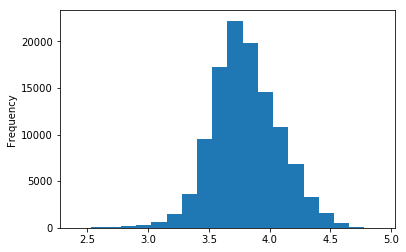

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

descrips[descrips.rating_global > 2.4].rating_global.plot(kind='hist', bins=20);

Looks like a normal distribution of mean ratings.  So in the absence of any ratings for a new beer, we can get an idea of what its mean will eventually be.

In [40]:
globmeans = np.random.permutation(descrips.rating_global.values)
head = globmeans[:-1000]
tail = globmeans[-1000:]
meanhead = np.mean(head)
devs = tail - meanhead
sumsqerr = np.dot(devs, devs)
rmse = np.sqrt(sumsqerr / len(devs))
print(f'standard deviation of the ratings: {np.std(head)}')
print(f'RMSE of the test batch: {rmse}')


standard deviation of the ratings: 0.2814249460599855
RMSE of the test batch: 0.27315472856393486


In [41]:
descrips.rating_global.mean()

3.8022169086147715

In [30]:
print(np.mean(checkins.groupby('beer_id')['rating_user'].mean()))
checkins.groupby('beer_id')['rating_global'].mean().mean()  # should be same as previous cell

3.8008000557179633


3.8022169086148034

In [98]:
checkins.columns

Index(['checkin_id', 'beer_id', 'user_id', 'rating_user', 'brewery_name',
       'beer_name', 'beer_style', 'rating_global', 'abv', 'beer_description'],
      dtype='object')

In [99]:
checkins['user_dev'] = checkins.rating_user.values - checkins.rating_global.values
u5plus = checkins.groupby('user_id').size() > 4
u_dev_stds = checkins[checkins.user_id.map(u5plus)].groupby('user_id').std()
np.mean(u_dev_stds)


checkin_id       5.583512e+07
beer_id          8.394311e+05
rating_user      4.161266e-01
rating_global    2.175186e-01
abv              1.471958e+00
user_dev         3.628700e-01
dtype: float64

That rating_user STD is artificially low as a predictor, from including the predicted rating.  
Try without the last rating:

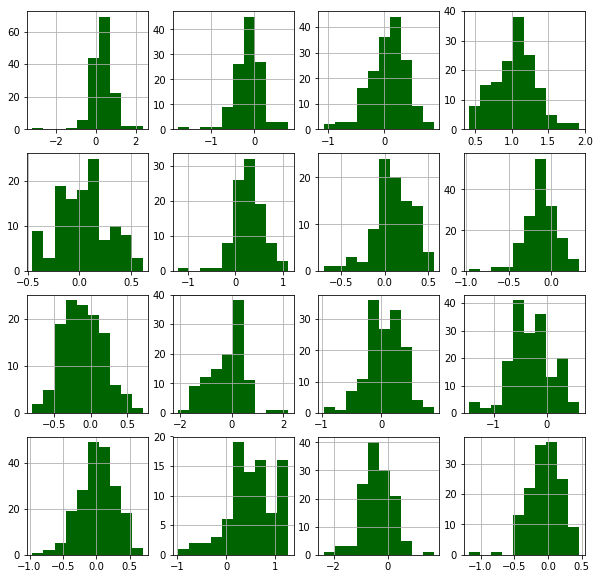

In [145]:
plt.figure(figsize=(10, 10))
subs = ((4,4,i) for i in range(1,17))
for uid in checkins[checkins.user_id.map(u5plus)].user_id.sample(16):
    pos = next(subs)
    udf = checkins[checkins.user_id==uid]
    plt.subplot(*pos)
    udf.user_dev.hist(color='darkgreen')
plt.savefig('sampled_user_devs.jpg')
plt.show()


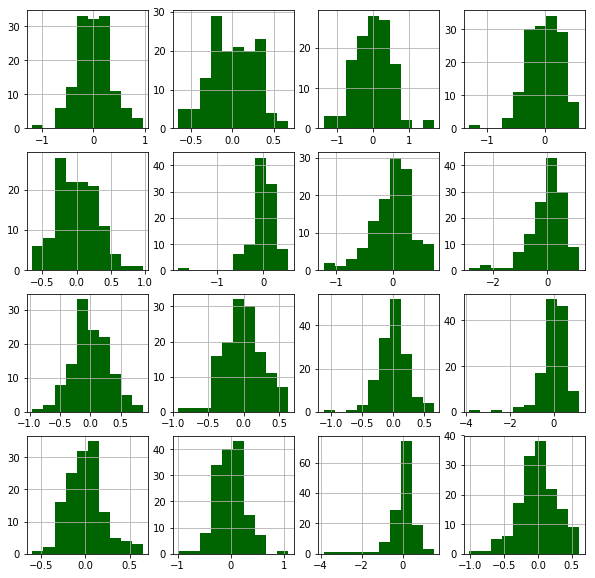

In [146]:
plt.figure(figsize=(10, 10))
subs = ((4,4,i) for i in range(1,17))
for uid in checkins[checkins.user_id.map(u5plus)].user_id.sample(16):
    pos = next(subs)
    udf = checkins[checkins.user_id==uid]
    plt.subplot(*pos)
    udf.user_pref.hist(color='darkgreen')

plt.savefig('sampled_user_prefs.jpg')
plt.show()

In [155]:
r5plus.sort_index(inplace=True)
r5plus.head()

,rating_user
user_id,
89,2.50
89,2.75
89,1.50
89,3.00
89,3.00


In [151]:
sum(lens)

1037030

In [173]:
r5plus = checkins[checkins.user_id.map(u5plus)].set_index('user_id').loc[:, ['rating_user', 'checkin_id', 'rating_global']]
r5plus.sort_index(inplace=True)
r5plus.sort_values(['user_id', 'checkin_id'], inplace=True)
lens = r5plus.groupby(r5plus.index).size().values
diffs = []
stds = []
i=0
ru = r5plus.rating_user.values
for l in tqdm(lens):
    mu = np.mean(ru[i:i+l-1])
    std = np.std(ru[i:i+l-1])
    diffs.append(mu - ru[i+l-1])
    stds.append(std)
    i += l

100%|██████████| 19264/19264 [00:01<00:00, 13037.51it/s]


In [174]:
rmse = np.sqrt(np.dot(diffs, diffs) / len(diffs))
rmse  # if predicting ratings based solely on the user's mean rating

0.48931543714847031

In [168]:
std5s = r5plus.groupby('user_id')['rating_user'].std()

In [170]:
std5s.mean()

0.41612662168128683

In [104]:
np.mean(stds)

0.45308538677000765

In [121]:
ustds = checkins.groupby('user_id')['user_pref'].std()

In [122]:
np.mean(ustds)

0.321905112140503

In [82]:
tenplus = checkins.groupby('beer_id').size() > 9
print(np.mean(checkins[checkins.beer_id.map(tenplus)].groupby('beer_id')['rating_user'].std()))
descrips.rating_global.std()

0.4814229682636554


0.28135405028010524

In [83]:
mostSamples = checkins[checkins.beer_id.map(tenplus)].set_index('beer_id').loc[:, ['rating_user', 'rating_global']]

In [65]:
from tqdm import tqdm

In [84]:
lens = mostSamples.groupby(mostSamples.index).size().values
len(lens)

31203

In [87]:
globers = []
userers = []
i=0
ru = mostSamples.rating_user.values
rg = mostSamples.rating_global.values
for l in tqdm(lens):
    mu = np.mean(ru[i:i+l-1])
    userers.append(mu - ru[i+l-1])
    globers.append(rg[i+l-1] - ru[i+l-1])
    i += l


100%|██████████| 31203/31203 [00:01<00:00, 29959.96it/s]

In [88]:
usermse = np.sqrt(np.dot(userers, userers) / len(userers))
globmse = np.sqrt(np.dot(globers, globers) / len(globers))
print(usermse, globmse)

0.54173236774 0.510480018418


In [97]:
aa = np.random.normal(size=100000)
bb = np.random.normal(size=100000)
cc = aa + bb
print(np.sqrt(np.dot(aa,aa) / 100000))
print(np.sqrt(np.dot(bb,bb) / 100000))
print(np.sqrt(np.dot(cc,cc) / 100000))

0.997702837146
0.998712671237
1.41081575085


In [34]:
descrips[['rating_global','abv']].corr()

,rating_global,abv
rating_global,1.000000,0.481737
abv,0.481737,1.000000


In [35]:
checkins[['rating_global','abv','rating_user','checkin_id']].corr()

,rating_global,abv,rating_user,checkin_id
rating_global,1.000000,0.523369,0.464471,0.070674
abv,0.523369,1.000000,0.251596,-0.001445
rating_user,0.464471,0.251596,1.000000,0.007014
checkin_id,0.070674,-0.001445,0.007014,1.000000


In [42]:
descrips.rating_global.std()

0.28135405028010524

In [43]:
# What proportion of the ratings are more than 1 std away from mean?
print(sum(descrips.rating_global > 4.0836) / len(descrips)) # for a normal distribution 
print(sum(descrips.rating_global < 3.5209) / len(descrips))  # it should be about 0.1587

0.15806851376471628
0.1342480304505621


So this is pretty close to normal distribution, although having a minimum allowed rating of 0.25 may be creating some righthand skew.

In [44]:
print(sum(descrips.rating_global > 4.3649) / len(descrips)) # .02275 for normal

0.02678587235549261


How about the ratings deviations within each beer or user?  These will be less normal since beers are biased toward one side of the ratings, as are individual users.

In [46]:
u3plus = checkins.groupby('user_id').size() > 2
byUser = checkins[checkins.user_id.map(u3plus)]
userMeans = byUser.groupby('user_id')['rating_user'].mean()
userStds = byUser.groupby('user_id')['rating_user'].std()

b3plus = checkins.groupby('beer_id').size() > 2
byBeer = checkins[checkins.beer_id.map(b3plus)]
beerMeans = byBeer.groupby('beer_id')['rating_user'].mean()
beerStds = byBeer.groupby('beer_id')['rating_user'].std()

In [47]:
print(userStds.mean(), userStds.std())
print(beerStds.mean(), beerStds.std())

0.3809809320290777 0.24150524427081413
0.4615900897105485 0.2215163786371017


In [48]:
userMeans.mean()

3.80129243110321

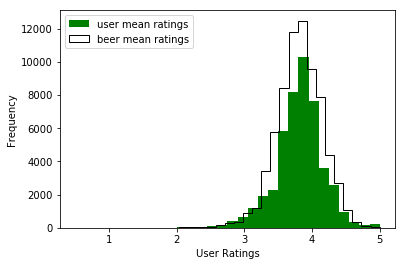

In [52]:
userMeans.plot(kind='hist', bins=30, color='g', label='user mean ratings')
beerMeans.plot(kind='hist', bins=30, color='k', histtype='step', label='beer mean ratings')
plt.legend(loc='upper left')
plt.xlabel('User Ratings');

In [217]:
checkins.groupby('beer_id').size().mean()

12.097052314773833

In [219]:
groupbeer = checkins.groupby('beer_id')

In [220]:
samples = groupbeer.size().values
meandiffs = groupbeer.rating_user.mean() - groupbeer.rating_global.mean()
len(samples)==len(meandiffs)

True

In [238]:
import seaborn as sns

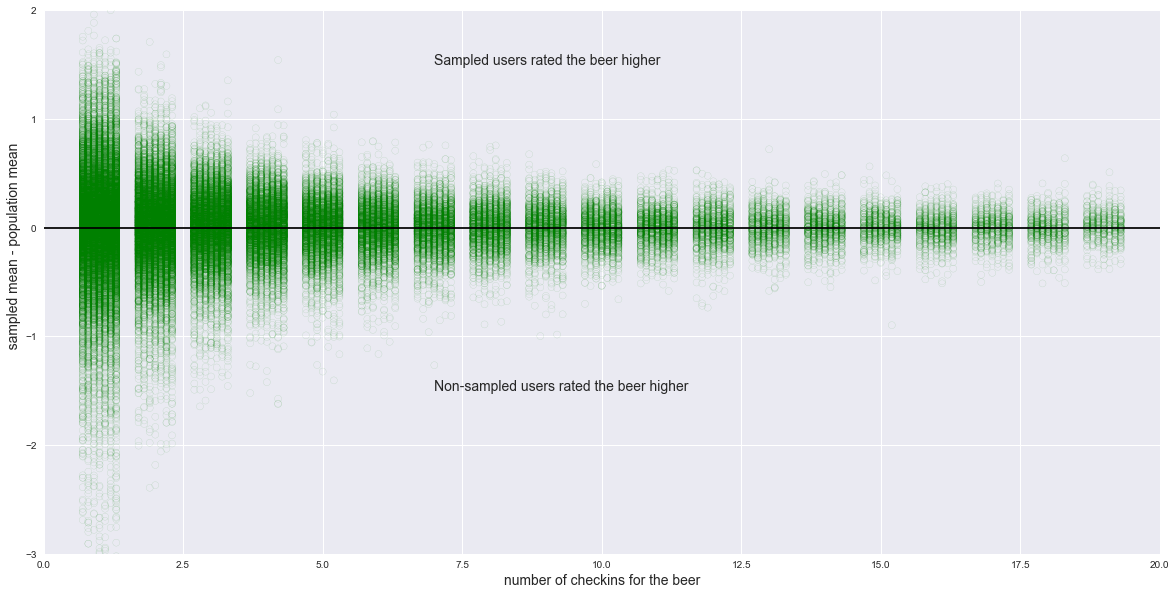

In [259]:
plt.figure(figsize=(20, 10))
lt20 = samples < 20
plt.scatter(samples[lt20] + np.random.choice(np.linspace(-.3, .3, 7), sum(lt20)),
            meandiffs[lt20], edgecolor='g', facecolor='none', alpha=0.2)
plt.xlim((0,20))
plt.ylim((-3, 2))
plt.axhline(0, color='k')
plt.text(7, 1.5, 'Sampled users rated the beer higher', fontsize=14)
plt.text(7, -1.5, 'Non-sampled users rated the beer higher', fontsize=14)
plt.xlabel('number of checkins for the beer', fontsize=14)
plt.ylabel('                   sampled mean - population mean', fontsize=14)
plt.savefig('beer_mean_ratings.jpg');

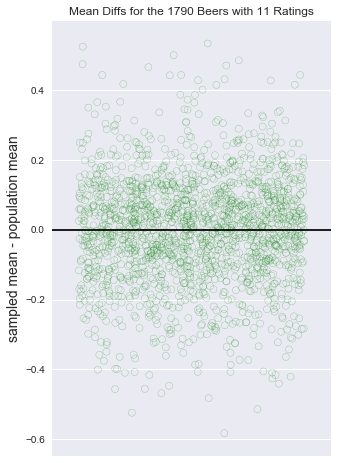

In [270]:
plt.figure(figsize=(5,8))
eq11 = samples==11
plt.scatter(samples[eq11] + np.random.uniform(-0.1, 0.1, sum(eq11)),
            meandiffs[eq11], edgecolor='g', facecolor='none', alpha=0.5)
plt.axhline(0, color='k')
plt.xticks([])
plt.ylabel('sampled mean - population mean', fontsize=14)
plt.title(f'Mean Diffs for the {sum(eq11)} Beers with 11 Ratings')
plt.savefig('eq11_beer_mean_ratings.jpg');

In [260]:
np.random.uniform?

Here's why the max_df param for the CountVectorizer was lowered to 0.17

In [352]:
# checking what the max doc freq is with max_df=0.71 for the CountVectorizer parameter)
docfreqs = vecs.toarray().sum(axis=0)

In [354]:
max(docfreqs[:-3]) / vecs.shape[0]

0.61982827299282994

In [367]:
counts = np.argsort(docfreqs[:-3])
topidx = counts[:-11:-1]
topwords = [cv.get_feature_names()[i] for i in counts[:-11:-1]]

In [370]:
print(list(zip(topwords, [docfreqs[i] / vecs.shape[0] for i in topidx])))

[('brewing', 0.61982827299282994), ('company', 0.34727803841727894), ('ipa', 0.2991148092413915), ('beer', 0.29614942020005314), ('hops', 0.29338762503319465), ('ale', 0.23142427193060106), ('brewed', 0.20581570328405771), ('hop', 0.16780561210940959), ('dry', 0.16090112419226343), ('brewery', 0.15913959458263255)]


Also, for future fun, a list of handpicked words for a simpler CountVectorizer

In [61]:
hops = ['galaxy','citra','mosaic','amarillo','nelson','columbus','cascade',
        'hallertau','nugget','motueka','centennial','goldings','rakau','idaho',
        'willamette','azacca','bravo','bru','cashmere','chinook','ctz','dorado',
        'sorachi','hbc','medusa','pekko','sterling','strata','summit','warrior',
        'ekuanot','sabro','zappa']
terms = ['yeast','oil','hash','powder','malt','grain','pineapple','coconut','stonefruit',
        'fruit','fruits','citrus','peach','peaches','lemon','lemons','grapefruit','grapefruits',
         'zest','pith','peel','candy','hop','hops','orange','oranges','marmelade','jam','rind',
        'lime','limes','melon','melons','juice','oak','neipa','east','west','hemisphere','pacific',
        'berry','berries','currant','currants','mead','lager','pilsener','rice','wheat','chocolate',
        'coffee','vanilla','spice','earth','evergreen','pine','piny','piney','forest']
adjs = ['fruity','tropical','dank','oily','resinous','bitter','sweet','malty','yeasty','fresh',
       'juicy','concentrated','hoppy','dry','hopped','ddh','tdh','hopping','intense','aromatic',
       'whirlpool','full','double','triple','rich','creamy','dark','sour','oaky','light','ripe',
       'overripe','green','red','black','white','stout','ipa','dipa','iipa','tipa','american',
       'floral','crisp','tangy','imperial','robust','warm',]

my_cv = CountVectorizer(vocabulary=hops+terms+adjs, binary=True)

my_vecs = my_cv.fit_transform(descrips.beer_description)
my_vecs.shape

(112970, 140)

In [62]:
# add the abv, style, and global rating in
my_vecs = hstack([my_vecs, vecs[:, -3:]])
my_vecs = csr_matrix(my_vecs)

Use the descriptions frame, with its descriptions, abv's, and style categories, to try to predict the global rating for an unseen/unrated new beer.  This has a couple of practical use cases, first of all for when a User needs to get a guess on a beer, before it has been rated, or maybe before it gets a certain threshold of ratings, and second in general for brewers who want to know which keywords correlate most with higher ratings, not as a way to trick the buyer with artificial descriptions, but as far as which ingredients or styles to pursue.

First let's see how it does with the simplified, handpicked vocab:

In [91]:
trainX, testX, trainY, testY = train_test_split(my_vecs[:, :-1], my_vecs[:, -1], test_size=0.01, random_state=0)

sgd = SGDRegressor(random_state=0, max_iter=1000)
sgd.fit(trainX, trainY.toarray().squeeze())

preds = sgd.predict(testX)
diffs = preds - testY.toarray().squeeze()
sumsq = np.dot(diffs, diffs)
rmse = np.sqrt(sumsq / len(diffs))
rmse

Now with all the cv words

In [177]:
# NOTE THAT THE STYLE CATEGORY IS BEING DROPPED HERE (second to last col)
trainX, testX, trainY, testY = train_test_split(vecs[:, :-2], vecs[:, -1], test_size=0.01, random_state=0)

In [178]:
testX.shape

(1130, 14938)

In [185]:
sgd = SGDRegressor(penalty='elasticnet', random_state=0, max_iter=1000, tol=1e-5, l1_ratio=0.05)

sgd.fit(trainX, trainY.toarray().squeeze())

preds = sgd.predict(testX)
diffs = preds - testY.toarray().squeeze()
sumsq = np.dot(diffs, diffs)
rmse = np.sqrt(sumsq / len(diffs))
rmse

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.05,
       learning_rate='invscaling', loss='squared_loss', max_iter=1000,
       n_iter=None, n_iter_no_change=5, penalty='elasticnet', power_t=0.25,
       random_state=0, shuffle=True, tol=1e-05, validation_fraction=0.1,
       verbose=0, warm_start=False)

That's better than the simpler cv, and significantly better than just guessing the mean global mean, which yielded 0.2813 st.dev.

Have a look at the predictions

In [187]:
print(list(zip(preds[:22], testY.toarray()[:22])))

[(3.5206482399001318, array([ 3.56213])), (4.3570375909686518, array([ 4.21571])), (3.9568666681072631, array([ 4.07704])), (3.5890003156550105, array([ 3.47297])), (3.9509959790886935, array([ 4.33382])), (4.13442465654055, array([ 4.23515])), (3.8184812177381975, array([ 3.88822])), (4.3183150725726538, array([ 4.04813])), (3.9035520839235982, array([ 4.00488])), (3.9958018257416379, array([ 3.96849])), (3.6225383700803482, array([ 3.53646])), (4.6446425933568154, array([ 4.46966])), (3.9382637688952218, array([ 4.10156])), (3.8716393931093425, array([ 3.80469])), (3.7528462519868184, array([ 3.67222])), (3.49080880649581, array([ 3.27376])), (3.5119668134221333, array([ 3.56088])), (3.6972109308304009, array([ 3.78667])), (3.6689697121643823, array([ 3.86613])), (3.5856979693436242, array([ 3.50909])), (3.9357592002425026, array([ 3.95489])), (3.7714298084203142, array([ 3.64267]))]


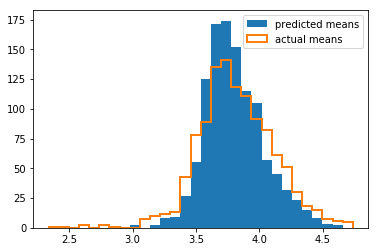

In [188]:
# make everything share same bins (StackO. 23617129)
bins = np.histogram(np.hstack((preds, testY.toarray().squeeze())), bins=30)[1]
plt.hist(preds, bins, label='predicted means')
plt.hist(testY.toarray(), bins, histtype='step', lw=2, label='actual means')
plt.legend();

It predicted closer to the mean than the actual means are distributed.

What are these weights telling a brewer about the users' tastes?

In [189]:
influencers = sorted(enumerate(sgd.coef_), key=lambda x: abs(x[1]), reverse=True)

In [190]:
influencers[:22]

[(12806, 0.47770733839219215),
 (2369, 0.46092486776698016),
 (5098, 0.46059268592524183),
 (550, 0.43351517205236112),
 (2479, 0.38151476132756995),
 (9599, -0.30686866603019219),
 (12172, 0.29571965559725649),
 (8770, 0.28890414611849885),
 (11420, 0.28228519615369052),
 (14937, 0.2801916318440158),
 (10539, 0.2765467513255756),
 (3322, -0.27540195402835654),
 (10045, 0.26577659853498675),
 (2544, 0.24732664552844733),
 (8818, 0.2461155749783113),
 (476, 0.24366834711302968),
 (11102, 0.23764535125737832),
 (2111, 0.23633652960407839),
 (3639, 0.23480609955404447),
 (2233, -0.23369711348822458),
 (819, -0.22994516739328694),
 (944, 0.22712177880498732)]

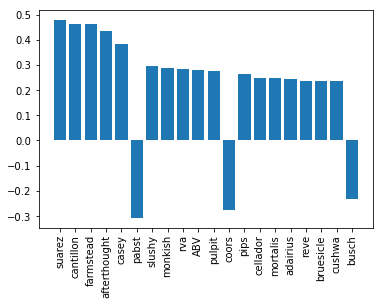

In [191]:
topX = 20
plt.bar(np.arange(topX), [(i[1]) for i in influencers[:topX]])
plt.xticks(np.arange(topX), [cv.get_feature_names()[i[0]] if i[0] !=14937 else 'ABV' 
                             for i in influencers[:topX] ], rotation='vertical');

In [127]:
descrips.groupby(descrips.beer_description.str.lower().str.contains('suarez'))['rating_global'].mean()

beer_description
False    3.801998
True     4.277082
Name: rating_global, dtype: float64

In [130]:
descrips.groupby(descrips.beer_description.str.lower().str.contains('busch'))['rating_global'].mean()

beer_description
False    3.802536
True     2.900265
Name: rating_global, dtype: float64

These are mostly weights that relate to a brewer's name, which is certainly helpful to the user of the recommender but not so to the brewer looking to brew something the world rates highly, unless the brewer wants to brew something under a pseudonym, which may not be a bad idea for Pabst, Coors, and Busch, according to the last chart.

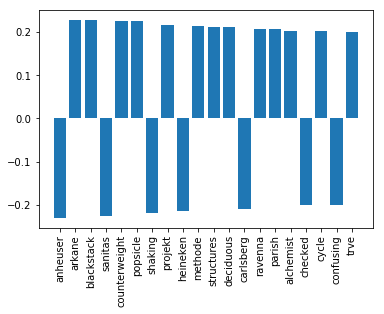

In [192]:
startID = 20
items = 20
plt.bar(np.arange(items), [(i[1]) for i in influencers[startID:startID+items]])
plt.xticks(np.arange(topX), [cv.get_feature_names()[i[0]] if i[0] !=14937 else 'ABV' 
                             for i in influencers[startID:startID+items] ], rotation='vertical');

Brief diversion into the timing of the checkins:

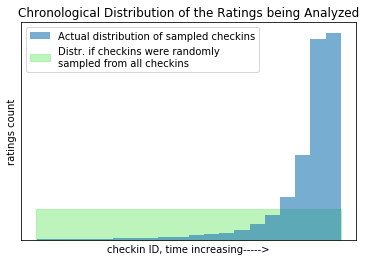

In [215]:
bins=20
checkins.checkin_id.hist(bins=bins, label='Actual distribution of sampled checkins', alpha=0.6)
plt.xlabel('checkin ID, time increasing----->')
plt.ylabel('ratings count')
plt.xticks([])
plt.yticks([])
plt.fill_between(np.linspace(0, checkins.checkin_id.max(), bins)
                 , len(checkins) / bins, color='lightgreen', alpha=0.6,
                label='Distr. if checkins were randomly\nsampled from all checkins')
plt.title('Chronological Distribution of the Ratings being Analyzed')
plt.legend(loc='upper left')
plt.savefig('ratings_chrono_distr.jpg');

In [118]:
# for each checkin, how much did the user rate the beer better or worse than rest of world?
checkins['beer_bias'] = checkins.rating_user - checkins.rating_global

In [119]:
# use that new column to also make a column that shows the user's overall "generosity" or lack thereof
userbiasdict = dict(checkins.groupby('user_id')['beer_bias'].mean())
checkins['user_bias'] = checkins.user_id.map(userbiasdict)
# and then see how much each rating deviates from that user's baseline bias/generosity
checkins['user_pref'] = checkins.beer_bias - checkins.user_bias

In [120]:
checkins.head()

,checkin_id,beer_id,user_id,rating_user,brewery_name,beer_name,beer_style,rating_global,abv,beer_description,user_dev,beer_bias,user_bias,user_pref
0,821797539,2095023,3340203,3.75,Stone Brewing,Stone Scorpion Bowl IPA,IPA - American,3.73789,7.5,To create a recipe so tropical and fruity with...,0.01211,0.01211,0.167938,-0.155828
1,793777280,2095023,2166716,3.50,Stone Brewing,Stone Scorpion Bowl IPA,IPA - American,3.73789,7.5,To create a recipe so tropical and fruity with...,-0.23789,-0.23789,-0.663801,0.425911
2,796454812,2095023,2607740,3.50,Stone Brewing,Stone Scorpion Bowl IPA,IPA - American,3.73789,7.5,To create a recipe so tropical and fruity with...,-0.23789,-0.23789,-0.207602,-0.030288
3,798199126,2095023,1040951,3.50,Stone Brewing,Stone Scorpion Bowl IPA,IPA - American,3.73789,7.5,To create a recipe so tropical and fruity with...,-0.23789,-0.23789,-0.078888,-0.159002
4,751560871,2095023,1338056,3.25,Stone Brewing,Stone Scorpion Bowl IPA,IPA - American,3.73789,7.5,To create a recipe so tropical and fruity with...,-0.48789,-0.48789,-0.027114,-0.460776


Try training a regressor on each user with over a certain threshold of ratings in the descriptions Frame

In [60]:
bigs = checkins.groupby('user_id').size() > 100

In [61]:
sum(bigs)

6277

In [62]:
freqs = checkins[checkins.user_id.map(bigs)]
len(freqs)

868621

In [63]:
freqs.user_id.nunique()

6277

In [ ]:
descrips.index

In [64]:
descrips.reset_index(inplace=True)
descrips.index

RangeIndex(start=0, stop=112970, step=1)

In [73]:
# now the descrips/vecs index can be looked up for each beer_id
beer_id_to_vecs_index = dict(zip(descrips.beer_id, descrips.index))

In [74]:
user_gen = (user for user in freqs.user_id.unique())

In [471]:
model = SGDRegressor(penalty='elasticnet', early_stopping=True, validation_fraction=0.1, 
                     random_state=0, max_iter=500, tol=1e-4, l1_ratio=0.15)

In [81]:
descrips.index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            114337, 114338, 114339, 114340, 114341, 114342, 114343, 114344,
            114345, 114346],
           dtype='int64', length=112970)

In [69]:
freqs.head(1)

,user_id,rating_user,brewery_name,beer_name,beer_style,rating_global,abv,beer_description,beer_bias,user_bias,user_pref
beer_id,,,,,,,,,,,
2095023,3340203,3.75,Stone Brewing,Stone Scorpion Bowl IPA,IPA - American,3.73789,7.5,To create a recipe so tropical and fruity with...,0.01211,0.167938,-0.155828


In [70]:
freqs.reset_index(inplace=True)

In [75]:
from tqdm import tqdm

In [78]:
rmses = []
for _ in tqdm(range(1000)):
    u = next(user_gen)
    udf = freqs[freqs.user_id == u]    
    vi = udf.beer_id.map(beer_id_to_vecs_index)

    xtrain, xtest, ytrain, ytest = train_test_split(vecs[vi, :],
                                                    udf.user_pref.values,
                                                    test_size = 0.1, random_state=0)
    model.fit(xtrain, ytrain)
    preds = model.predict(xtest)
    diffs = preds - ytest
    sumsq = np.dot(diffs, diffs)
    rmse = np.sqrt(sumsq / len(diffs))
    rmses.append(rmse)

  1%|          | 6/1000 [00:04<12:27,  1.33it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
  1%|          | 10/1000 [00:06<10:02,  1.64it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
  2%|▏         | 16/1000 [00:10<09:24,  1.74it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
  2%|▏         | 19/1000 [00:12<09:45,  1.68it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/li

In [77]:
# WITH BEER NAME AND BREWERY NAME ADDED TO BAG OF WORDS, AND WITH ABV/5.0, 10-0.71 min-max_df, FIRST 1000 USERS
#   AND WITH OHE HOT BEER STYLES
np.mean(rmses)

0.40666412277531083

In [79]:
# WITH BEER NAME AND BREWERY NAME ADDED TO BAG OF WORDS, AND WITH ABV/5.0, 10-0.71 min-max_df, 2nd 1000 USERS
#   AND WITH OHE HOT BEER STYLES
np.mean(rmses)

0.40866462084021121

In [403]:
# WITH JUST DESCRIPS, NO ABV, NO BREWERYNAME, NO BEERNAME, FIRST 1000 USERS
np.mean(rmses)

0.41770131939694782

While that's effective, if we're going to train a model for each user, we might as well add the brewery name into the bag of words, and feature the a.b.v. as well.

In [481]:
# WITH BEER NAME AND BREWERY NAME ADDED TO BAG OF WORDS, AND WITH ABV/10.0, FIRST 1000 USERS
np.mean(rmses)

0.41045456724343349

In [482]:
# how much of a factor was abv for the last user? 
model.coef_[-1]

0.029312253664937806

In [484]:
# WITH BEER NAME AND BREWERY NAME ADDED TO BAG OF WORDS, AND WITH ABV/10.0, SECOND 1000 USERS
np.mean(rmses)

0.41219801463392686

In [486]:
# WITH BEER NAME AND BREWERY NAME ADDED TO BAG OF WORDS, AND WITH ABV/10.0, THIRD 1000 USERS
np.mean(rmses)

0.40342371577009351

In [488]:
# WITH BEER NAME AND BREWERY NAME ADDED TO BAG OF WORDS, AND WITH ABV/10.0, FOURTH 1000 USERS
np.mean(rmses)

0.39471921597581955

In [491]:
# WITH BEER NAME AND BREWERY NAME ADDED TO BAG OF WORDS, AND WITH ABV/10.0, FIFTH 1000 USERS
np.mean(rmses)

0.40582003370423486

In [493]:
# WITH BEER NAME AND BREWERY NAME ADDED TO BAG OF WORDS, AND WITH ABV/10.0, SIXTH 1000 USERS
np.mean(rmses)

0.36608485008657315

Try different min and max doc_freqs:

In [563]:
cv = CountVectorizer(stop_words='english', min_df=8, max_df=0.67, binary=True)
vecs = cv.fit_transform(descrips.beer_description)
vecs.shape

(112970, 17250)

In [564]:
vecs = hstack([vecs, descrips.abv.values[:, np.newaxis] / 5.0])

In [565]:
vecs = csr_matrix(vecs)

In [61]:
vecs.shape

(112970, 14939)

In [567]:
model = SGDRegressor(penalty='elasticnet', early_stopping=True, validation_fraction=0.1, 
                     random_state=0, max_iter=500, tol=1e-4, l1_ratio=0.15)

In [568]:
rmses = []
for _ in tqdm(range(1000)):
    u = next(user_gen)
    udf = freqs[freqs.user_id == u]    
    vi = udf.beer_id.map(beer_id_to_vecs_index)

    xtrain, xtest, ytrain, ytest = train_test_split(vecs[vi, :],
                                                    udf.user_pref.values,
                                                    test_size = 0.1, random_state=0)
    model.fit(xtrain, ytrain)
    preds = model.predict(xtest)
    diffs = preds - ytest
    sumsq = np.dot(diffs, diffs)
    rmse = np.sqrt(sumsq / len(diffs))
    rmses.append(rmse)

  2%|▏         | 19/1000 [00:13<11:25,  1.43it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
  2%|▏         | 22/1000 [00:15<10:28,  1.56it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
  2%|▏         | 23/1000 [00:16<11:40,  1.39it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
  3%|▎         | 29/1000 [00:20<10:35,  1.53it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/l

In [531]:
# WITH BEER NAME AND BREWERY NAME ADDED TO BAG OF WORDS, AND WITH ABV/10.0, wider min-max_df, FIRST 1000 USERS
np.mean(rmses)

0.40935367156602692

In [533]:
# WITH BEER NAME AND BREWERY NAME ADDED TO BAG OF WORDS, AND WITH ABV/10.0, wider min-max_df, SECOND 1000 USERS
np.mean(rmses)

0.41102899786202451

In [551]:
# WITH BEER NAME AND BREWERY NAME ADDED TO BAG OF WORDS, AND WITH ABV/5.0, wider min-max_df, THIRD 1000 USERS
np.mean(rmses)

0.40099016637930346

In [554]:
# WITH BEER NAME AND BREWERY NAME ADDED TO BAG OF WORDS, AND WITH ABV/2.0, wider min-max_df, FOURTH 1000 USERS
np.mean(rmses)

0.39267224585736399

abv / 5.0 worked slightly better than abv / 2.0

In [562]:
# WITH BEER NAME AND BREWERY NAME ADDED TO BAG OF WORDS, AND WITH ABV/5.0, 10-0.8 min-max_df, FIFTH 1000 USERS
np.mean(rmses)

0.40347976746241548

In [569]:
# WITH BEER NAME AND BREWERY NAME ADDED TO BAG OF WORDS, AND WITH ABV/5.0, 8-0.67 min-max_df, SIXTH 1000 USERS
np.mean(rmses)

0.3640813027042098

In [95]:
# boolean array marking which users rated exactly 4 beers
fours = checkins.groupby('user_id').size() == 4

In [96]:
sum(fours)

8989

In [97]:
# use the boolean array as a map to select the 36K checkins of these 9K users
fours = checkins[checkins.user_id.map(fours)]
fours.head()

,user_id,rating_user,brewery_name,beer_name,beer_style,rating_global,abv,beer_description,beer_bias,user_bias,user_pref
beer_id,,,,,,,,,,,
2595866,836231,3.25,Stone Brewing,Stone Liberty Station POMMA Said Knock You Out,IPA - Red,3.75349,7.5,Red India Pale Ale w/ Pommegranate made by Pin...,-0.50349,-0.192930,-0.310560
2595866,310841,4.00,Stone Brewing,Stone Liberty Station POMMA Said Knock You Out,IPA - Red,3.75349,7.5,Red India Pale Ale w/ Pommegranate made by Pin...,0.24651,0.375592,-0.129083
2595866,2395919,4.00,Stone Brewing,Stone Liberty Station POMMA Said Knock You Out,IPA - Red,3.75349,7.5,Red India Pale Ale w/ Pommegranate made by Pin...,0.24651,0.257727,-0.011218
301381,13106,3.50,Hop Valley Brewing Company,Citrus Mistress IPA,IPA - American,3.73392,6.5,"Munich malt, 4 different hops and grapefruit p...",-0.23392,-0.038338,-0.195582
2222013,3650609,4.00,Claremont Craft Ales,35 Miles NE,IPA - New England,3.82279,7.0,hazy IPA,0.17721,0.334958,-0.157747


In [136]:
four_gen = (user for user in fours.user_id.unique())

In [100]:
fours.reset_index(inplace=True)

In [112]:
fours['beer_description'] = fours.brewery_name + ' ' + fours.beer_name + ' ' + fours.beer_description

/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [113]:
fours.head(1)

,beer_id,user_id,rating_user,brewery_name,beer_name,beer_style,rating_global,abv,beer_description,beer_bias,user_bias,user_pref
0,2595866,836231,3.25,Stone Brewing,Stone Liberty Station POMMA Said Knock You Out,IPA - Red,3.75349,7.5,Stone Brewing Stone Liberty Station POMMA Said...,-0.50349,-0.19293,-0.31056


In [101]:
rmses = []
for _ in tqdm(range(1000)):
    u = next(four_gen)
    udf = fours[fours.user_id == u]    
    vi = udf.beer_id.map(beer_id_to_vecs_index)

    xtrain, xtest, ytrain, ytest = train_test_split(vecs[vi, :],
                                                    udf.user_pref.values,
                                                    test_size = 0.25, random_state=0)
    model.fit(xtrain, ytrain)
    preds = model.predict(xtest)
    diffs = preds - ytest
    sumsq = np.dot(diffs, diffs)
    rmse = np.sqrt(sumsq / len(diffs))
    rmses.append(rmse)

  3%|▎         | 30/1000 [00:10<05:30,  2.93it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
 46%|████▌     | 458/1000 [02:36<03:08,  2.87it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
100%|██████████| 1000/1000 [05:55<00:00,  2.74it/s]


In [102]:
# just fours!  first 1000
# (so this is users who have only rated 3 beers and we want to predict the fourth, so results won't be great)
np.mean(rmses)

0.2884738178097056

OK, that's way too low, and highlights the need to calculate the user biases only on the training data.

In [103]:
# here's the cell where the biases were calculated
# Make a column that shows the user's overall "generosity" or lack thereof
userbiasdict = dict(checkins.groupby('user_id')['beer_bias'].mean())
checkins['user_bias'] = checkins.user_id.map(userbiasdict)
# and then see how much each rating deviates from that user's baseline bias/generosity
checkins['user_pref'] = checkins.beer_bias - checkins.user_bias

35956

In [135]:
def user_models(df, test_frac, wordvecs, beer_2_vec_map, user_generator, batch_size, rando=0):
    '''
    @df input has columns indicating the user's ratings biases,
    but the training will only use the biases calculate on itself.
    '''
    rmses = []
    for _ in tqdm(range(batch_size)):
        u = next(user_generator)
        udf = df[df.user_id == u]
        ratings = len(udf)
        # use the last @test_frac fraction of each user's checkins as the test group
        split = int(ratings * (1-test_frac))
        utrain = udf.iloc[:split, :]
        utest = udf.iloc[split:, :]
        # make the corresponding split to the vector indices, vi
        vi = udf.beer_id.map(beer_2_vec_map)
        trainvecs = wordvecs[vi[:split], :]
        testvecs = wordvecs[vi[split:], :]
        # calculate the user's avg generosity/stinginess towards KNOWN ratings
        known_bias = utrain.beer_bias.mean()
        train_targets = utrain.beer_bias - known_bias
        # especially after only 3 ratings, those training targets will be changing with each rating,
        ##  so these results will not be great if the user's ratings vary much
        stop_early = len(utrain) > 10
        model = SGDRegressor(penalty='elasticnet', early_stopping=stop_early, validation_fraction=0.1, 
                     random_state=rando, max_iter=500, tol=1e-4, l1_ratio=0.15)
        model.fit(trainvecs, train_targets)
        preds = model.predict(testvecs)
        diffs = preds - utest.user_pref
        sumsq = np.dot(diffs, diffs)
        rmse = np.sqrt(sumsq / len(diffs))
        rmses.append(rmse)
    return np.mean(rmses)

Keep this randomly sampled first user's four checkins as an example of how the first 3 checkins can  
be vastly misleading for the fourth checkin.

In [116]:
fours[fours.user_id == 836231]

,beer_id,user_id,rating_user,brewery_name,beer_name,beer_style,rating_global,abv,beer_description,beer_bias,user_bias,user_pref
0,2595866,836231,3.25,Stone Brewing,Stone Liberty Station POMMA Said Knock You Out,IPA - Red,3.75349,7.5,Stone Brewing Stone Liberty Station POMMA Said...,-0.50349,-0.19293,-0.31056
26960,3383299,836231,3.50,The Fermentorium Beverage Co.,Pilot 0X61: South African DIPA,IPA - Imperial / Double,3.87289,9.0,The Fermentorium Beverage Co. Pilot 0X61: Sout...,-0.37289,-0.19293,-0.17996
28099,3043409,836231,3.25,Boston Beer Company,Harvest New England IPA,IPA - New England,3.45455,4.6,Boston Beer Company Harvest New England IPA Ha...,-0.20455,-0.19293,-0.01162
33865,1258262,836231,4.00,One Mile Brewing Co,No Limits IPA,IPA - American,3.69079,6.5,One Mile Brewing Co No Limits IPA Hop driven I...,0.30921,-0.19293,0.50214


In [137]:
user_models(df=fours,
            test_frac=0.25,
            wordvecs=vecs,
            beer_2_vec_map=beer_id_to_vecs_index,
            user_generator=four_gen,
            batch_size=1000)

100%|██████████| 1000/1000 [04:48<00:00,  3.50it/s]


0.25414542955815506

So after you get these user preference predictions down to this .25 rmse, you have to calculate what the user would actually rate the beers.  Start with the global mean, add this predicted user preference, and then add a user bias, which should just consist of the known bias of the (user-specific) training set.  This sort of formulation should work best with constant updates to the user's profile (model), adjusting the user bias as you go, and re-training on the new means every checkin.  The overhead isn't much, just a series of 10-20K floats per user, which can be used to initialize the training with a warm start for quicker convergence.

#### For all users with at least 5 ratings, train this NLP/abv SGDRegressor on all but their last rating, then predict the last, and compare how those predictions do compared to the smart baseline predictions with Pearson similarities between users.

In [54]:
fiveplus = checkins.groupby('user_id').size() > 4
fiveplus = checkins[checkins.user_id.map(fiveplus)]
print(len(fiveplus))
fiveplus.user_id.nunique()

1037030


19264

In [52]:
def test_last_split(df, last_x=1):
    '''
    Split trainset to be all but last one, or more, of
    each User's profile of checkins, chronologically, and then
    test on the most recent checkin(s).
    --------------
    Inputs--
    
    df:  DataFrame with rows of User/Beer/Rating combos, a.k.a. 'checkins', 
        chronologically ordered, but not necessarily user-ordered
    
    last_x:  how many rows to use for testing.  defaults to 1, the most recent checkin.
    
    --------------
    Returns-- A User-stratified split into training and testing 
    
    '''
    
    trainers = []
    testers = []
    
    # Loop over each user in the DataFrame input
    for u in df.user_id.unique():
        udf = df[df.user_id == u]
        n_ratings = len(udf)
        # use the @last_x integer, default=1, of each user's checkins as the test group
        split = n_ratings - last_x  # (first) index of test rating(s)
        trainers.append(udf.iloc[:split, :])  # train-test split
        testers.append(udf.iloc[split:, :])

    return trainers, testers

In [70]:
def test_last(df, wordvecs, beer_2_vec_map, last_x=1, rando=0):
    '''
    Train sklearn.SGDRegressor on all but last one, or more, of
    each User's profile of checkins, chronologically, and then
    test on the most recent one(s).
    --------------
    Inputs--
    
    df: has columns indicating the user's ratings biases.
        (Training will only use the biases calculated on train data.)
        
    wordvecs: feature matrix, a sparse csr_matrix of binary encoded
        bag-of-words filled from the beer name, brewery name, and textual
        description of the beer, provided by brewery.  Also featured are 
        the scaled abv (alc. by vol.) content of each beer, and a binary 
        category for the beer's style.
        
    beer_2_vec_map:  converts the df's beer ID to wordvecs row index
    
    last_x:  how many rows to use for testing.  defaults to 1, the most recent checkin.
    
    rando:  random seed for the SGD model
    --------------
    Returns-- a dict mapping User ID to a tuple of rmse errors, (baseline, baseline+model).
    
    '''
    
    scores = dict()
    #nlp_rmses = []  (scores dict is being used to build result, instead of these 2 lists)
    #baseline_rmses = []
    
    # Loop over each user in the DataFrame input
    for u in tqdm(df.user_id.unique()):
        udf = df[df.user_id == u]
        ratings = len(udf)
        # use the @last_x integer, default=1, of each user's checkins as the test group
        split = ratings - last_x  # (first) index of test rating(s)
        utrain = udf.iloc[:split, :]  # train-test split
        utest = udf.iloc[split:, :]
        # make the corresponding split to the vector indices, vi
        vi = udf.beer_id.map(beer_2_vec_map)
        trainvecs = wordvecs[vi[:split], :]
        testvecs = wordvecs[vi[split:], :]
        # calculate the user's avg generosity/stinginess towards KNOWN ratings
        known_bias = utrain.beer_bias.mean()
        # target the direction and amount that the user deviated from user's normal bias
        
        train_targets = utrain.beer_bias - known_bias
    
        # train the model, stopping early when there enough training samples to justify validating
        stop_early = len(utrain) > 10
        model = SGDRegressor(penalty='elasticnet', early_stopping=stop_early, validation_fraction=0.1, 
                     random_state=rando, max_iter=500, tol=1e-5, l1_ratio=0.75)
        model.fit(trainvecs, train_targets)
        
        preds = model.predict(testvecs)
        
        baseline_preds = utest.rating_global + known_bias
        # shrink model prediction
        nlp_preds = (0.3 + 1 / trainvecs.shape[0]) * preds + baseline_preds
        
        # store the baseline rmse
        diffs_base = baseline_preds - utest.rating_user
        sumsq = np.dot(diffs_base, diffs_base)
        rmse_base = np.sqrt(sumsq / len(diffs_base))
        #baseline_rmses.append(rmse_base)
        
        # store the (baseline + model) rmse
        diffs_nlp = nlp_preds - utest.rating_user
        sumsq = np.dot(diffs_nlp, diffs_nlp)
        rmse_nlp = np.sqrt(sumsq / len(diffs_nlp))
        #nlp_rmses.append(rmse_nlp)
        
        scores[u] = (rmse_base, rmse_nlp)
        
    return scores #np.mean(baseline_rmses), np.mean(nlp_rmses)

In [429]:
def test_last(df, wordvecs, beer_2_vec_map, last_x=1, rando=0):
    '''
    @df input has columns indicating the user's ratings biases,
    but the training will only use the biases calculated on itself.
    '''
    # keep scores in this dict
    scores = dict()
    #nlp_rmses = []
    #baseline_rmses = []
    
    for u in tqdm(df.user_id.unique()):
        udf = df[df.user_id == u]
        ratings = len(udf)
        # use the @last_x of each user's checkins as the test group
        split = ratings - last_x
        utrain = udf.iloc[:split, :]
        utest = udf.iloc[split:, :]
        # make the corresponding split to the vector indices, vi
        vi = udf.beer_id.map(beer_2_vec_map)
        trainvecs = wordvecs[vi[:split], :]
        testvecs = wordvecs[vi[split:], :]
        # calculate the user's avg generosity/stinginess towards KNOWN ratings
        known_bias = utrain.beer_bias.mean()
        train_targets = utrain.beer_bias - known_bias
        
        stop_early = len(utrain) > 10
        model = SGDRegressor(penalty='elasticnet', early_stopping=stop_early, validation_fraction=0.1, 
                     random_state=rando, max_iter=500, tol=1e-5, l1_ratio=0.75)
        model.fit(trainvecs, train_targets)
        
        preds = model.predict(testvecs)
        baseline_preds = utest.rating_global + known_bias
        nlp_preds = (0.3 + 1 / trainvecs.shape[0]) * preds + baseline_preds
        
        diffs_base = baseline_preds - utest.rating_user
        sumsq = np.dot(diffs_base, diffs_base)
        rmse_base = np.sqrt(sumsq / len(diffs_base))
        #baseline_rmses.append(rmse_base)
        
        diffs_nlp = nlp_preds - utest.rating_user
        sumsq = np.dot(diffs_nlp, diffs_nlp)
        rmse_nlp = np.sqrt(sumsq / len(diffs_nlp))
        #nlp_rmses.append(rmse_nlp)
        
        scores[u] = (rmse_base, rmse_nlp)
        
    return scores #np.mean(baseline_rmses), np.mean(nlp_rmses)

In [57]:
# commenting out the first line here, after running it already.  It's unnecessary even once.
#fiveplus['beer_description'] = fiveplus.brewery_name + ' ' + fiveplus.beer_name + ' ' + fiveplus.beer_description
fiveplus.reset_index(inplace=True)  # reset the indices so the mapper to BOW vecs works

In [75]:
from tqdm import tqdm
scores = test_last(fiveplus[(fiveplus.user_id == 2607740) | (fiveplus.user_id == 1040951)], vecs, beer_id_to_vecs_index)

100%|██████████| 2/2 [00:31<00:00, 10.19s/it]


In [76]:
scores

{1040951: (0.42734569444444404, 0.92986868026985947),
 2607740: (0.13190660194174786, 0.021195383357971664)}

In [155]:
short_test = fiveplus[(fiveplus.user_id == 2607740) | (fiveplus.user_id == 1040951)]
print(len(short_test), short_test.user_id.nunique())

249 2


In [156]:
baseline_error, nlp_error = test_last(short_test, vecs, beer_id_to_vecs_index)

100%|██████████| 2/2 [00:01<00:00,  1.06s/it]


In [157]:
print(f'test_baseline_error = {baseline_error}')
print(f'test_nlp_error = {nlp_error}')

test_baseline_error = 0.27962614819309595
test_nlp_error = 0.3123180189674395


In [158]:
baseline_error, nlp_error = test_last(fiveplus, vecs, beer_id_to_vecs_index)

  2%|▏         | 331/19264 [02:51<2:43:17,  1.93it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
  2%|▏         | 390/19264 [03:23<2:32:02,  2.07it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
  2%|▏         | 467/19264 [04:07<2:31:09,  2.07it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
  3%|▎         | 571/19264 [04:57<2:24:28,  2.16it/s]/Applications/anaconda/lib/python3.6/site-pa

In [159]:
# all 19K users and 1M checkins
print(f'test_baseline_error = {baseline_error}')
print(f'test_nlp_error = {nlp_error}')

test_baseline_error = 0.3081064876194298
test_nlp_error = 0.3126100764886783


In [180]:
fivers = (u for u in fiveplus.user_id.unique())

In [181]:
for _ in range(11):
    u=next(fivers)
u=next(fivers)
u

1073271

In [182]:
u_df = fiveplus[fiveplus.user_id == u]
len(u_df)

144

In [183]:
u_df.tail(10)

,beer_id,user_id,rating_user,brewery_name,beer_name,beer_style,rating_global,abv,beer_description,beer_bias,user_bias,user_pref
389595,1016561,1073271,4.50,3 Stars Brewing Company,Above the Clouds,Farmhouse Ale - Saison,3.57005,6.3,3 Stars Brewing Company Above the Clouds Style...,0.92995,0.432022,0.497928
389608,2452100,1073271,4.25,Old Ox Brewery,Goal Crusher,IPA - International,3.70614,7.5,Old Ox Brewery Goal Crusher This amazing mix o...,0.54386,0.432022,0.111838
389611,659313,1073271,4.00,Blue Mountain Brewery,A Hopwork Orange,IPA - American,3.63205,7.0,Blue Mountain Brewery A Hopwork Orange An IPA ...,0.36795,0.432022,-0.064072
389676,2922244,1073271,4.25,AleSmith Brewing Company,Gregarious Nature,IPA - American,3.78609,7.0,AleSmith Brewing Company Gregarious Nature Two...,0.46391,0.432022,0.031888
389768,2485082,1073271,4.00,Center Of The Universe Brewing Company,Chameleon IPA Green,IPA - American,3.80481,6.8,Center Of The Universe Brewing Company Chamele...,0.19519,0.432022,-0.236832
389803,2365122,1073271,4.25,Terrapin Beer Co.,"So Fresh & So Green, Green - Citra",IPA - American,3.72725,6.6,"Terrapin Beer Co. So Fresh & So Green, Green ...",0.52275,0.432022,0.090728
389819,2415824,1073271,4.25,6 Bears & A Goat Brewing Company,Trop Hours,Pale Ale - American,3.58494,5.6,6 Bears & A Goat Brewing Company Trop Hours Am...,0.66506,0.432022,0.233038
389823,2534246,1073271,4.25,Northern Outer Banks Brewing Company,Corolla Lager,Lager - American Amber / Red,3.53250,6.0,Northern Outer Banks Brewing Company Corolla L...,0.71750,0.432022,0.285478
389828,19562,1073271,4.00,Mad Fox Brewing Company,Defender American Pale Ale,Pale Ale - American,3.37204,5.2,Mad Fox Brewing Company Defender American Pale...,0.62796,0.432022,0.195938
389832,28524,1073271,4.25,Port City Brewing,Optimal® Wit,Witbier,3.62283,4.9,Port City Brewing Optimal® Wit GABF: 2013 Gold...,0.62717,0.432022,0.195148


In [184]:
test_last(u_df, vecs, beer_id_to_vecs_index)

100%|██████████| 1/1 [00:01<00:00,  1.76s/it]


{1073271: (0.19651279720279735, 0.1777578412714842)}

In [374]:
np.random.seed(0)

In [241]:
sample1K = np.random.choice(fiveplus.user_id.unique(), 1000)

In [242]:
fiveplus['sampled'] = fiveplus.user_id.apply(lambda uid: uid in sample1K)

/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [375]:
sum(fiveplus.sampled)

52139

In [256]:
sample1K_scores = test_last(fiveplus[fiveplus.sampled], vecs, beer_id_to_vecs_index, rando=1)

  2%|▏         | 18/973 [00:10<08:06,  1.96it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
  8%|▊         | 77/973 [00:41<08:45,  1.70it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
  8%|▊         | 82/973 [00:44<08:55,  1.67it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
 15%|█▍        | 144/973 [01:17<07:49,  1.76it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/line

In [257]:
np.mean([val for val in sample1K_scores.values()], axis=0)  # ([baseline error only, baseline plus regression error])

array([ 0.31365449,  0.31276952])

In [ ]:
sizes = dict(fiveplus.groupby('user_id').size())
by_size = [sizes[key] for key in sample1K_scores.keys()]
baselines = [v[0] for v in sample1K_scores.values()]
nlps = [v[1] for v in sample1K_scores.values()]

# assertion test
len(by_size) == len(baselines) == len(nlps)

In [201]:
plt.figure(figsize=(15, 10))
plt.scatter(by_size, np.array(baselines) - np.array(nlps), facecolors='none', edgecolors='b', alpha=0.5)
plt.axhline(0.25, c='g')
plt.axhline(-0.25, c='g')
plt.axhline(0, c='k', alpha=0.3)
plt.ylabel('<--  Baseline model better      | \
        NLP model better -->')
plt.xlabel('Size of training set')
plt.ylim(-0.75, 0.75);

With max_df set to 0.17, removing top 8 most frequent words:

In [378]:
# also lowered early stopping tol param in the model, from 1e-4 to 1e-5
sample1K_scores = test_last(fiveplus[fiveplus.sampled], vecs, beer_id_to_vecs_index, rando=1)

  1%|▏         | 13/973 [00:07<08:09,  1.96it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
  2%|▏         | 18/973 [00:10<08:01,  1.98it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
  3%|▎         | 31/973 [00:17<07:49,  2.01it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
  3%|▎         | 33/973 [00:18<08:33,  1.83it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/linea

In [379]:
np.mean([val for val in sample1K_scores.values()], axis=0)  # ([baseline error only, baseline plus regression error])

array([ 0.31365449,  0.31241381])

In [380]:
# try a different sample
np.random.seed(1)
sample500 = np.random.choice(fiveplus.user_id.unique(), 500)
fiveplus['sampled'] = fiveplus.user_id.apply(lambda uid: uid in sample500)
sample500_scores = test_last(fiveplus[fiveplus.sampled], vecs, beer_id_to_vecs_index, rando=1)
print(np.mean([val for val in sample500_scores.values()], axis=0))

/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  5%|▍         | 23/489 [00:13<04:05,  1.90it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
  5%|▌         | 26/489 [00:15<05:05,  1.52it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
  6%|▌         | 27/489 [00:15<05:07,  1.50it/s]/Applications

[ 0.30772315  0.30482691]


Take a look at the coefficients for one user, to see how sparse they might be, since the scores for the baseline seem to be essentially the same as for NLP/abv/style predictions.

In [381]:
u = sample500[-1]
udf = fiveplus[fiveplus.user_id == u]
udf.shape

(145, 13)

In [384]:
ratings = len(udf)
# use the last rating only as test
split = ratings - 1
utrain = udf.iloc[:split, :]
utest = udf.iloc[split:, :]
# make the corresponding split to the vector indices, vi
vi = udf.beer_id.map(beer_id_to_vecs_index)
trainvecs = vecs[vi[:split], :]
testvecs = vecs[vi[split:], :]
# calculate the user's avg generosity/stinginess towards KNOWN ratings
known_bias = utrain.beer_bias.mean()
train_targets = utrain.beer_bias - known_bias
        
stop_early = len(utrain) > 10
model = SGDRegressor(penalty='elasticnet', early_stopping=stop_early, validation_fraction=0.1, 
                     random_state=1, max_iter=500, tol=1e-5, l1_ratio=0.15)
model.fit(trainvecs, train_targets)
        
preds = model.predict(testvecs)
baseline_preds = utest.rating_global + known_bias
# Adjust this mix before using again
nlp_preds = (0.3 + 1 / trainvecs.shape[0]) * preds + baseline_preds
        
diffs_base = baseline_preds - utest.rating_user
sumsq = np.dot(diffs_base, diffs_base)
rmse_base = np.sqrt(sumsq / len(diffs_base))

diffs_nlp = nlp_preds - utest.rating_user
sumsq = np.dot(diffs_nlp, diffs_nlp)
rmse_nlp = np.sqrt(sumsq / len(diffs_nlp))

print(rmse_base, rmse_nlp)
        

0.968302777778 1.02550631114


In [385]:
udf.tail()

,beer_id,user_id,rating_user,brewery_name,beer_name,beer_style,rating_global,abv,beer_description,beer_bias,user_bias,user_pref,sampled
926456,3038137,2348465,5.00,Bottle Logic Brewing,Time Trials,IPA - Imperial / Double New England,3.96855,7.8,Bottle Logic Brewing Time Trials A mosaic and ...,1.03145,0.271575,0.759875,True
926461,2810477,2348465,4.00,Left Coast Brewing Co.,Simply Citra,Pale Ale - New England,3.49517,5.5,Left Coast Brewing Co. Simply Citra New Englan...,0.50483,0.271575,0.233255,True
926464,1226915,2348465,4.00,Four Sons Brewing,King Coco,Red Ale - Imperial / Double,3.87233,10.0,Four Sons Brewing King Coco Coconuts for days.,0.12767,0.271575,-0.143905,True
926466,2945404,2348465,4.75,FiftyFifty Brewing Co.,I Did It All For the Cookie,Brown Ale - Imperial / Double,3.70066,9.0,FiftyFifty Brewing Co. I Did It All For the Co...,1.04934,0.271575,0.777765,True
926468,2722461,2348465,3.25,The Bruery,Rice & Beans (2018),Blonde Ale,3.94005,7.7,The Bruery Rice & Beans (2018) Rice and Beans ...,-0.69005,0.271575,-0.961625,True


In [390]:
# how many terms were weighted in the trained model?
len(np.nonzero(model.coef_)[0])

1754

In [396]:
# and how many of the terms in the single test rating were in those 1754?
lastbeerID = udf.loc[udf.index[-1], 'beer_id']
vect = beer_id_to_vecs_index[lastbeerID]
vect = vecs.toarray()[vect, :]

In [398]:
np.nonzero(vect)

(array([  170,   481,  1339,  1401,  2110,  2634,  2828,  2974,  3472,
         4244,  4992,  5144,  5317,  5612,  6435,  6696,  7373,  7601,
         7858,  8559, 11152, 13399, 14077, 14937, 14938]),)

In [399]:
weighted = [feat for feat in np.nonzero(vect)[0] if feat in set(np.nonzero(model.coef_)[0])]

In [401]:
print(weighted)

[170, 481, 1339, 1401, 2110, 2634, 2828, 2974, 3472, 4244, 4992, 5144, 5317, 5612, 6435, 6696, 7373, 7601, 7858, 8559, 11152, 13399, 14077, 14937, 14938]


In [402]:
# so at least all words in the test rating description were seen and fit in the training ratings.
## how much did the dot product contribute?
model.predict(testvecs)

array([ 0.18636445])

The user rated this beer .69 below the global mean, where he tended to rate beers .27 over the mean, so the baseline  
was off by .96, and the NLP/abv/style model was off another 0.19 in the wrong direction, which got mutiplied down to  
.06, for a total of 1.02 wrong.  Let's see why the model leaned the wrong way on this:

In [405]:
print([cv.get_feature_names()[word] for word in np.nonzero(vect)[0][:-2]])

['2018', 'add', 'base', 'beans', 'bruery', 'character', 'cinnamon', 'coffee', 'creamy', 'dosing', 'extra', 'features', 'fit', 'fresh', 'heavy', 'horchata', 'just', 'lactose', 'like', 'mia', 'rice', 'tierra', 'vanilla']


It's really hard to believe the the training ratings, all 144 of them, included descriptions with 'horchata', 'cinnamon', and 'tierra', so maybe the random initializations of the SGD Regressor didn't get pushed to zero by the regularizers.  But let's see where the model went wrong before adjusting regularizers.

In [417]:
coefs = [model.coef_[x] for x in np.nonzero(vect)[0][:-2]]
print(sorted(list(zip(coefs, [cv.get_feature_names()[word]
                              for word in np.nonzero(vect)[0][:-2]])),
             key=lambda tup: abs(tup[0]), reverse=True))

[(0.063637492968631651, 'character'), (0.049800001767233204, 'fresh'), (-0.043483593152654244, 'just'), (0.04100373763695872, 'vanilla'), (-0.035334403770771787, 'like'), (0.029497633207047933, 'beans'), (0.024502455017940034, 'features'), (0.02235863034129186, 'cinnamon'), (0.011553906457230553, 'rice'), (-0.010920592089463405, 'coffee'), (0.0090194635071176258, 'lactose'), (-0.0088118005099497802, 'creamy'), (-0.0086635022053072799, 'base'), (0.0067852116403035647, 'dosing'), (0.0067852116403035647, 'horchata'), (0.0067852116403035647, 'mia'), (0.0067852116403035647, 'tierra'), (0.0055841977006605807, 'fit'), (0.0050789552507178645, 'heavy'), (0.0035017682115361937, 'extra'), (-0.0029137693361845083, '2018'), (0.0027293080727261339, 'add'), (0.002074350911327369, 'bruery')]


In [413]:
sum(coefs)

0.18735508654730298

In [5]:
# had the user tried a blonde ale before the test?
'Blonde Ale' in udf.beer_style.iloc[:-1]

NameError: name 'udf' is not defined

In [491]:
# try pushing some more weights to zero
model = SGDRegressor(penalty='elasticnet', early_stopping=stop_early, validation_fraction=0.1, 
                     random_state=1, max_iter=100, tol=1e-5, l1_ratio=0.75)
model.fit(trainvecs, train_targets)
        
preds = model.predict(testvecs)
baseline_preds = utest.rating_global + known_bias
# this mix of prediction on baseline is not very good, as it
## reduces the NLP aspect as more words are learned, which may be reverse of good mix
nlp_preds = (0.3 + 1 / trainvecs.shape[0]) * preds + baseline_preds
        
diffs_base = baseline_preds - utest.rating_user
sumsq = np.dot(diffs_base, diffs_base)
rmse_base = np.sqrt(sumsq / len(diffs_base))

diffs_nlp = nlp_preds - utest.rating_user
sumsq = np.dot(diffs_nlp, diffs_nlp)
rmse_nlp = np.sqrt(sumsq / len(diffs_nlp))

print(rmse_base, rmse_nlp)

0.968302777778 1.02439600448


Barely better. see how it fares on sample500

In [492]:
np.random.seed(1)
sample500 = np.random.choice(fiveplus.user_id.unique(), 500)
fiveplus['sampled'] = fiveplus.user_id.apply(lambda uid: uid in sample500)
sample500_scores = test_last(fiveplus[fiveplus.sampled], vecs, beer_id_to_vecs_index, rando=1)
print(np.mean([val for val in sample500_scores.values()], axis=0))

/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
  6%|▋         | 31/489 [00:17<04:37,  1.65it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
  7%|▋         | 36/489 [00:20<03:47,  1.99it/s]/Applications/anaconda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1219: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
  9%|▊         | 42/489 [00:24<04

[ 0.30772315  0.30463446]


In [431]:
# vs. (.3077, .3048) with l1=0.15 in elasticnet

coefs = [model.coef_[x] for x in np.nonzero(vect)[0][:-2]]
print(sorted(list(zip(coefs, [cv.get_feature_names()[word]
                              for word in np.nonzero(vect)[0][:-2]])),
             key=lambda tup: abs(tup[0]), reverse=True))

[(0.063662178004126671, 'character'), (0.049732278331194188, 'fresh'), (-0.043785656852763082, 'just'), (0.040501732606832763, 'vanilla'), (-0.035720248303768645, 'like'), (0.029580759492395421, 'beans'), (0.023966031928233506, 'features'), (0.022053733167995984, 'cinnamon'), (0.011343376941701904, 'rice'), (-0.009927475188164378, 'coffee'), (0.0084905683606552942, 'lactose'), (-0.0083185806795426833, 'base'), (-0.0081361642462119549, 'creamy'), (0.0063762141014153456, 'dosing'), (0.0063762141014153456, 'horchata'), (0.0063762141014153456, 'mia'), (0.0063762141014153456, 'tierra'), (0.0052082504019391549, 'fit'), (0.0043961449926575927, 'heavy'), (0.0031807966938111202, 'extra'), (0.0024689257767401317, 'add'), (-0.0016727371125001089, '2018'), (0.0014625024310899188, 'bruery')]


In [455]:
sum(['vanilla' in udf.beer_description.iloc[i].split() for i in range(len(udf)-1)])

9

In [456]:
sum(['character' in udf.beer_description.iloc[i].split() for i in range(len(udf)-1)])

5

In [458]:
sum(['blonde' in udf.beer_description.iloc[i].split() for i in range(len(udf)-1)])

1

In [460]:
# find the rating for that beer that had 'blonde' in descrip
blondie = udf[udf.beer_description.str.contains('blonde')]

In [82]:
len(blondie)

NameError: name 'blondie' is not defined

In [490]:
list(blondie.loc[blondie.index, 'beer_description'])

['SLO Brew Blueberry A SLO Brew Classic loved near and far, this light-bodied blonde ale is infused with organic blueberry flavor to bring you a fresh “crop to can” aroma and balanced body. With this can in hand, you’re ripe for enhanced well being.']

Train-test-split for using the last_x ratings for the testers

In [4]:
def test_last_split(df, last_x=1):
    '''
    Split trainset to be all but last one, or more, of
    each User's profile of checkins, chronologically, and then
    test on the most recent checkin(s).
    --------------
    Inputs--
    
    df:  DataFrame with rows of User/Beer/Rating combos, a.k.a. 'checkins', 
        chronologically ordered, but not necessarily user-ordered
    
    last_x:  how many rows to use for testing.  defaults to 1, the most recent checkin.
    
    --------------
    Returns-- A User-stratified split into training and testing 
    
    '''
    
    trainers = []
    testers = []
    
    # Loop over each user in the DataFrame input
    for u in df.user_id.unique():
        udf = df[df.user_id == u]
        n_ratings = len(udf)
        # use the @last_x integer, default=1, of each user's checkins as the test group
        split = n_ratings - last_x  # (first) index of test rating(s)
        trainers.append(udf.iloc[:split, :])  # train-test split
        testers.append(udf.iloc[split:, :])

    return trainers, testers

In [ ]:
trainers, testers = 